# DHIS2 - Tuning HDBSCAN parameters and running clustering

# Inputs
- Absolute path to the directory with .csv files
- Absolute path to the shapefile for your geography
- Absolute path to the shapefile for your geofile

```
!pip install --upgrade pip
!pip install fuzzywuzzy
!conda install -c conda-forge pyshp
!conda install -c conda-forge pyproj
!conda install -c conda-forge proj4
```

In [50]:
import os
import re
import glob
import conda
import hdbscan
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from config import Config
from collections import Counter
from matplotlib import pyplot as plt
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection

In [51]:
DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/'
SHAPEFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/geo_files/gadm36_BGD_shp/gadm36_BGD_2'
GEOFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/geo_files/geos_svrs.xlsx'
OUTPUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/maternalhealth'
GEO_LEVEL = 'districts'

In [52]:
def get_files_list(input_dir):
    input_files = glob.glob(input_dir + "/District_*_NAME.csv")
    return input_files


def read_data(files_list):
    data_dict = {}
    for file in files_list:
        data_dict[file] = pd.read_csv(file)
        data_dict[file].rename(columns={'True':'geo'}, inplace=True)
    return data_dict


def check_type(ddict):
    check_list = []
    for key, df in ddict.items():
        df_check_list = [var == 'int64' or var == 'float64' for var in df.dtypes]
        check_list.append(all(df_check_list))
    return all(check_list)


def check_geovar(ddict):
    check_list = []
    for key, df in ddict.items():
        if df.columns[0] == 'geo':
            check_list.append(True)
        else:
            check_list.append(False)
    return all(check_list) 


def check_data(ddict):
    return check_type(ddict) and check_geovar(ddict)


def concat_data1(ddict):
    dlist = []
    for key, df in ddict.items():
        print(key[-13:-9])
        df['year'] = key[-13:-9]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist, axis=0, sort=True)
    out['geo'] = out['geo'].astype(str).str.cat(out['year'].astype(str), sep=" ")
    out = out.drop(['year'], axis=1)
    return out


def concat_data2(ddict):
    dlist = []
    for key, df in ddict.items():
        print(key[-13:-9])
        df['year'] = key[-13:-9]
        try:
            df['year'] = df['year'].astype(int)
        except ValueError:
            print("No year number in file names")
        dlist.append(df)
    out = pd.concat(dlist, axis=0, sort=True)
    if Counter([len(str(var)) for var in out['geo']]) != 1:
        out['geo'] = out['geo'].astype(str).str.pad(width=2, side='left', fillchar='0')
    return out


def create_output_dir(output_dir):
    dir_list = [name for name in os.listdir(os.path.split(output_dir)[0]) if os.path.isdir(name)]
    try:
        os.mkdir(os.path.split(output_dir)[1])
    except FileExistsError:
        print("Directory already present!")


def evaluate_hdbscan(input_df, min_samples, min_cluster_size, 
                     output, cluster_selection_method, 
                     fmin_samples, fmin_cluster_size,
                     prune=False, plot=True):
    samples = list(itertools.product(min_samples, min_cluster_size))
    counter = 0
    models = pd.DataFrame(columns=['min_samples',
                                   'min_cluster_size',
                                   'num_clusters_including_unclustered',
                                   'percent_of_unclustered_geos',
                                   'percent_of_maxclass',],index=range(len(samples)))
    geo = input_df['geo']
    input_df = input_df.drop('geo', axis=1)
    df = input_df.copy(deep=True)
    for iteration in samples:
        model = hdbscan.HDBSCAN(min_samples=int(iteration[0]), 
                                min_cluster_size=int(iteration[1]), 
                                metric='euclidean', 
                                algorithm='best',
                                cluster_selection_method=cluster_selection_method, prediction_data=False).fit(df)
        models.loc[counter,'min_cluster_size'] = iteration[1]
        models.loc[counter, 'min_samples'] = iteration[0]
        models.loc[counter, 'num_clusters_including_unclustered'] = len(Counter(model.labels_))
        tmp_dict = dict(Counter(model.labels_))
        total = sum([v for k,v in tmp_dict.items()])
        tmp_dict = {k:round(v/total*100,2) for k,v in tmp_dict.items()}
        try:
            models.loc[counter, 'percent_of_unclustered_geos'] = tmp_dict.pop(-1)
        except KeyError as error:
            models.loc[counter, 'percent_of_unclustered_geos'] = 0 
        if len(tmp_dict) > 1:
            models.loc[counter, 'percent_of_maxclass'] = tmp_dict[max(tmp_dict.items(), key=operator.itemgetter(1))[0]]
        else:
            models.loc[counter, 'percent_of_maxclass'] = 100
        counter += 1
    if prune:
        out_model = hdbscan.HDBSCAN(min_samples=int(fmin_samples), 
                                min_cluster_size=int(fmin_cluster_size), 
                                metric='euclidean', 
                                algorithm='best',
                                cluster_selection_method=cluster_selection_method, prediction_data=False).fit(df)

    else:
        out_model = None
    models.to_csv(os.path.split(output)[1] + "/models_overview.csv", index=False, index_label=False)
    if plot:
        plt.rcParams['figure.figsize'] = [20,10]
        plt.plot(models['num_clusters_including_unclustered'], label='Number of clusters including unclustered')
        plt.savefig(os.path.split(output)[1] + "/finetune_parameteres.jpeg")
        plt.legend()
        plt.show()
    del(input_df, df)
    return models, out_model


def cluster_data(input_df, f_min_samples, f_min_cluster_size, cluster_selection_method):
    df = input_df.copy(deep=True)
    cluster_data = df.drop(['geo', 'year'], axis=1)
    print(cluster_data.columns)
    model = hdbscan.HDBSCAN(min_samples=int(f_min_samples), 
                            min_cluster_size=int(f_min_cluster_size), 
                            metric='euclidean', 
                            algorithm='best', 
                           cluster_selection_method=cluster_selection_method).fit(cluster_data)
    print(Counter(model.labels_))
    df['class'] = model.labels_
    return df
    

def create_mapobject(shp_path, shp_name):
    m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='c')
    m.readshapefile(shapefile=shp_path, name=shp_name, drawbounds=True)
    return m


def colors2clusters(df_input, cluster_var):
    df = df_input.copy(deep=True)
    df['colors'] = df[cluster_var].astype('category')
    labs = list(df['colors'].cat.categories)
    clusters = list(df[cluster_var].unique())
    colors = sns.color_palette('Paired', len(clusters)).as_hex()
    df['colors'] = df['colors'].cat.rename_categories(colors)
    cols = list(df['colors'].cat.categories)
    return df, list(zip(labs,cols))


def data2map(mapobj, mapobj_key, data, data_key):
    for district in mapobj.districts_info:
        district['CLUSTER'] = data.loc[data[data_key] == district[mapobj_key],'colors'][0]
    return mapobj


def plot_geos(mapobj, mapobj_key, labels_colors, title, output):
    geo_names = []
    for shape_dict in mapobj.districts_info:
        geo_names.append(int(shape_dict[mapobj_key]))
    ax = plt.gca()
    for info, shape in zip(mapobj.districts_info, mapobj.districts):
        poly = Polygon(shape, facecolor=info['CLUSTER'], edgecolor=info['CLUSTER'])
        ax.add_patch(poly)
    legend_elements = [Line2D([0], [0], marker="s", color=col, label=label, markerfacecolor=col, markersize=25)
                   for label, col in labels_colors] 
    plt.legend(handles=legend_elements, loc='upper right',borderpad=2)
    plt.title(title)
    plt.savefig(os.path.join(output, title + ".jpeg"))
    plt.show()
    plt.close()


def plot_clusters(input_df, shapefile, geo_level, project, output):
    df = input_df.copy(deep=True)
    plt.rcParams['figure.figsize'] = [10,10]
    for year in sorted(list(df['year'].unique())):
        m = create_mapobject(shp_path=shapefile,shp_name=geo_level)
        tmp = df[df['year'] == year]
        print(tmp['year'].unique())
        m = data2map(mapobj=m, mapobj_key='CC_2', data=tmp, data_key='geo')
        plot_geos(mapobj=m, mapobj_key='CC_2',labels_colors=labs_cols, title=project + str(year), output=output)
    

def get_statistics(input_df, output, title):
    df = input_df.copy(deep=True)
    out = {}
    for year in df['year'].unique():
        tmp = df[df['year'] == year]
        variables = list(tmp.drop(['year', 'geo', 'class', 'colors'], axis=1).columns)
        tmp = tmp.drop(['year','geo'], axis=1)
        tmpgroupby = tmp.groupby('class')
        output_year = [] 
        for variable in variables:
            print(variable)
            tmp = tmpgroupby[variable].agg([np.mean, np.std, np.max, np.min]).transpose()
            tmp['var'] = variable
            output_year.append(tmp)
        out[year] = pd.concat(output_year, axis=0)
        out[year].to_csv(os.path.join(output, title+"_" +str(year) + ".csv"),index=False, index_label=False)
    return out


def update_geo1(input_df, input_geo, geo_var):
    df = input_df.copy(deep=True)
    geodata = pd.read_excel(input_geo)
    geodata['dv'] = geodata['dv'].astype(str)
    geodata['zl'] = geodata['zl'].astype(str)
    geodata['dv'] = geodata['dv'].str.pad(width=2,side='left',fillchar='0')
    geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
    geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
    geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name2']]
    geodata = geodata.drop_duplicates()
    display(geodata.head())
    display(df.head())
    df = df.merge(right=geodata, left_on='geo', right_on=geo_var)
    print(df.shape)
    df = df.drop(['dv', 'Div_Name', 'zl', 'Zila_Name2', 'geo'], axis=1)
    df.rename(columns={'geo_full':'geo'}, inplace=True)
    return df


def update_geo2(input_df, input_geo, geo_var):
    df = input_df.copy(deep=True)
    geodata = pd.read_excel(input_geo)
    geodata['dv'] = geodata['dv'].astype(str)
    geodata['zl'] = geodata['zl'].astype(str)
    geodata['dv'] = geodata['dv'].str.pad(width=2,side='left',fillchar='0')
    geodata['zl'] = geodata['zl'].str.pad(width=2,side='left',fillchar='0')
    geodata['geo_full'] = geodata['dv'].str.cat(geodata['zl'], sep='')
    geodata = geodata[['geo_full','dv','Div_Name','zl','Zila_Name2']]
    geodata = geodata.drop_duplicates()
    df = df.merge(right=geodata, left_on='geo', right_on=geo_var)
    df.rename(columns={'geo_full':'geo'}, inplace=True)
    return df

def imput_missing(input_df):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if df[var].dtype != 'object':
            if df[var].isna().value_counts()[0]/df[var].shape[0] != 1.:
                tmp = df[var].fillna(np.mean(df[var]))
                df = df.drop(var,axis=1)
                df[var] = tmp
    return df


def output_class(input_df):
    df = input_df.copy(deep=True)
    out = list()
    for geo_var in df['geo'].unique():
        tmp = df[df['geo'] == geo_var]
        tmp = tmp[['geo','year', 'class']]
        tmp = tmp.pivot(index='geo', columns='year', values='class')
        tmp.reset_index(inplace=True)
        out.append(tmp)
    output = pd.concat(out, axis=0)
    output = output.reset_index(drop=True)
    return output

def output_table(input_df):
    df = input_df.copy(deep=True)
    remove = ['geo','year','colors']
    columns = df.columns
    variables = list(set(columns).difference(set(remove)))
    print(variables)
    out_min = df[variables].groupby('class').min().round(4)
    out_max = df[variables].groupby('class').max().round(4)
    out_mean = df[variables].groupby('class').mean().round(1)
    t = out_min.astype(str).add(' - ').add(out_mean.astype(str))
    t = t.astype(str).add(' - ').add(out_max.astype(str))
    return t


## PART 1: Fine-tuning the clustering model
### STEP 1: Get files list

In [53]:
dfiles = get_files_list(input_dir=DATA)
dfiles

['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2012_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2013_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2018_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2009_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2015_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2014_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2011_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2010_NAME.csv',
 '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2016_NAME.csv',
 '/Users/e

### STEP 2: Read data

In [54]:
ddata = read_data(files_list=dfiles)

### STEP 3: Check data 

In [55]:
dcheck = check_data(ddict=ddata)
dcheck

False

### STEP 4: Concat data 

In [56]:
ddf = concat_data1(ddict=ddata)

2012
2013
2018
2009
2015
2014
2011
2010
2016
2017


### STEP 5: Create output dir

In [57]:
create_output_dir(output_dir=OUTPUT)

Directory already present!


### STEP 6: Data and geo clean up child health data

In [58]:
ddf['geo'] = ddf['geo'].str.replace(" District", "")
ddf.head()

,01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Total Complicated Mother,01MaternalHealth: Total No. of pregnant mothers with obstetric complication,...,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_fw product distribution closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for logistic closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for vaccine/diluent closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_supply book closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_temperature chart closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_zip lock bag closing balance,AntenatalCare(ANC): 1st Visit ANC,AntenatalCare(ANC): 2nd Visit ANC,AntenatalCare(ANC): 3rd & more ANC,geo
0,50.0,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006,5637.0,3244.0,...,47.8,36.9,36.9,50.9,330.0,311.0,NaN,NaN,NaN,Bagerhat 2012
1,0.0,11.3,88.2,0.0770,0.08,0.42,0.0042,0.0008,463.0,316.0,...,64.0,38.0,29.0,32.0,218.0,534.0,NaN,NaN,NaN,Bandarban 2012
2,20.0,49.4,50.0,0.0763,0.31,1.13,0.0113,0.0031,3558.0,3360.0,...,19.0,14.0,18.0,8.0,5.0,1240.0,NaN,NaN,NaN,Barguna 2012
3,0.0,65.4,34.5,0.0039,0.04,0.78,0.0078,0.0004,4223.0,4128.0,...,55.0,50.0,45.0,47.0,897.0,2428.0,NaN,NaN,NaN,Barishal 2012
4,26.0,22.1,77.4,0.2378,0.16,2.75,0.0275,0.0016,9348.0,9075.0,...,43.0,32.0,30.0,29.0,734.9,2772.4,NaN,NaN,NaN,Bhola 2012


In [59]:

maternalhealth_vars = [var for var in ddf.columns if bool(re.search(r"01MaternalHealth: ",var))]
print(maternalhealth_vars)
maternalhealth_data = ddf[['geo']+maternalhealth_vars]
maternalhealth_data = maternalhealth_data.drop(['01MaternalHealth: Total Complicated Mother', 
                                          '01MaternalHealth: Total No. of pregnant mothers with obstetric complication',
                                          '01MaternalHealth: Total birth in EmONC facilities', 
                                          '01MaternalHealth: Total deliveries in EmONC facilities',
                                          '01MaternalHealth: Total still birth at EmOC facility'],axis=1)
maternalhealth_data.head()


['01MaternalHealth: % of maternal death reported individually with causes of death', '01MaternalHealth: Institutional C-section rate', '01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)', '01MaternalHealth: Maternal Case fatality rate (EmOC)', '01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC', '01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC', '01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC', '01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC', '01MaternalHealth: Total Complicated Mother', '01MaternalHealth: Total No. of pregnant mothers with obstetric complication', '01MaternalHealth: Total birth in EmONC facilities', '01MaternalHealth: Total deliveries in EmONC facilities', '01MaternalHealth: Total still birth at EmOC facility']


,geo,01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC
0,Bagerhat 2012,50.0,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006
1,Bandarban 2012,0.0,11.3,88.2,0.0770,0.08,0.42,0.0042,0.0008
2,Barguna 2012,20.0,49.4,50.0,0.0763,0.31,1.13,0.0113,0.0031
3,Barishal 2012,0.0,65.4,34.5,0.0039,0.04,0.78,0.0078,0.0004
4,Bhola 2012,26.0,22.1,77.4,0.2378,0.16,2.75,0.0275,0.0016


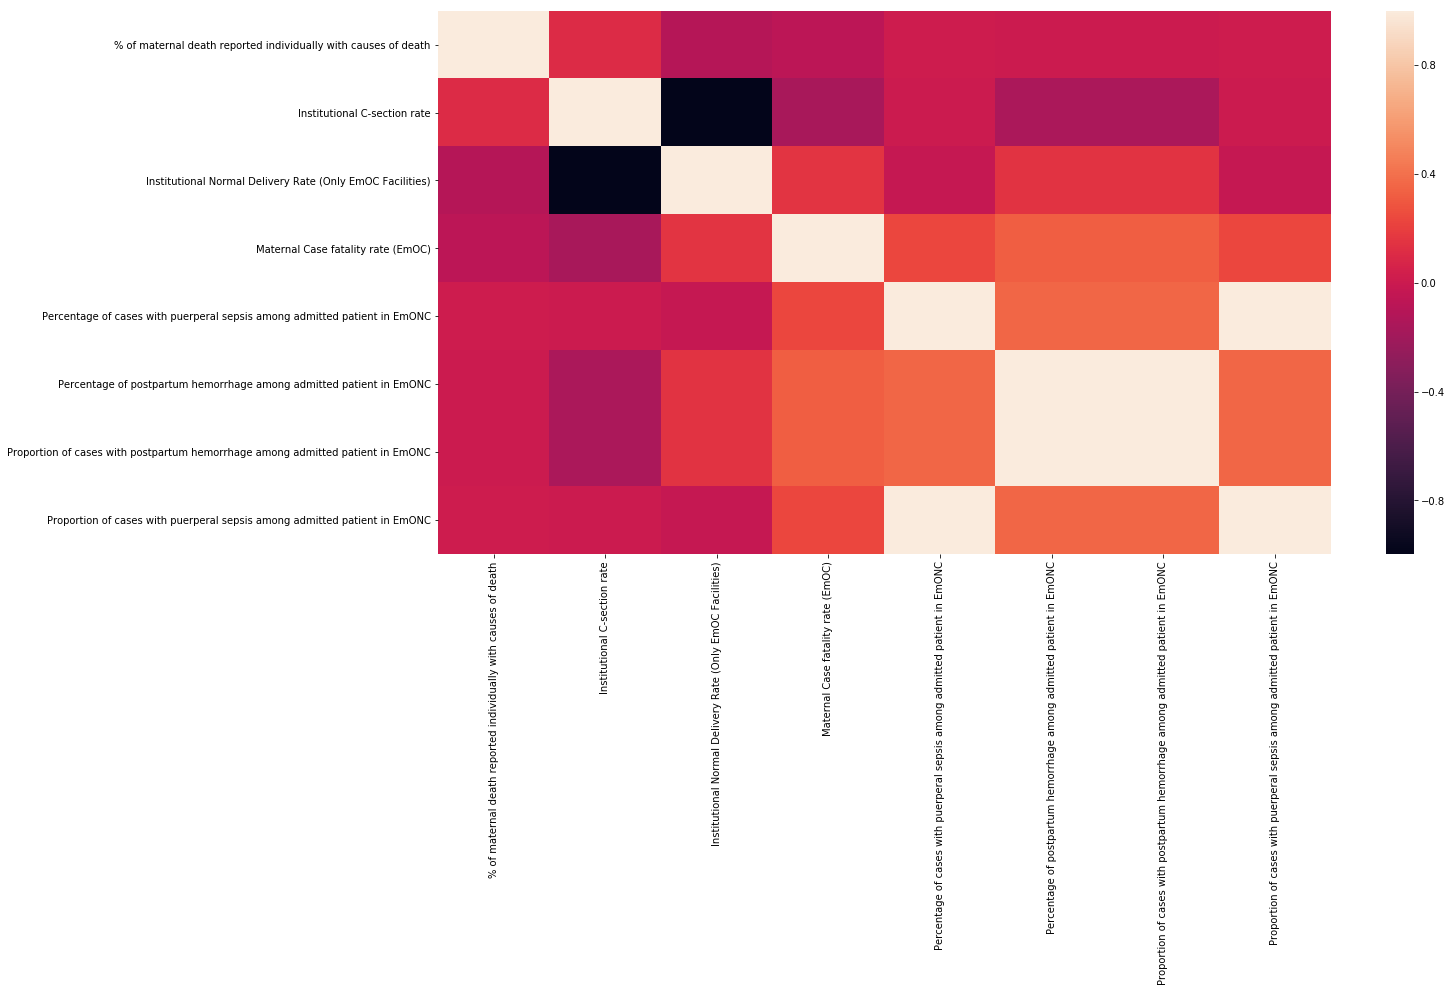

In [60]:
corr = maternalhealth_data.corr()
labels = [var.replace("01MaternalHealth: ", "") for var in corr.columns]
sns.heatmap(corr, 
        xticklabels=labels,
        yticklabels=labels)

In [61]:
for var in maternalhealth_data.columns:
    print(maternalhealth_data[var].isna().value_counts()/maternalhealth_data.shape[0])
maternalhealth_data = imput_missing(input_df=maternalhealth_data)  
for var in maternalhealth_data.columns:
    print(maternalhealth_data[var].isna().value_counts()/maternalhealth_data.shape[0])

False    1.0
Name: geo, dtype: float64
False    0.920312
True     0.079687
Name: 01MaternalHealth: % of maternal death reported individually with causes of death, dtype: float64
False    1.0
Name: 01MaternalHealth: Institutional C-section rate, dtype: float64
False    1.0
Name: 01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities), dtype: float64
False    1.0
Name: 01MaternalHealth: Maternal Case fatality rate (EmOC), dtype: float64
False    1.0
Name: 01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC, dtype: float64
False    1.0
Name: 01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC, dtype: float64
False    1.0
Name: 01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC, dtype: float64
False    1.0
Name: 01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC, dtype: float64
False    1.0
Name: geo, dtype: flo

### STEP 6: Fine tune and analyze the data and obtain the output of paramaters

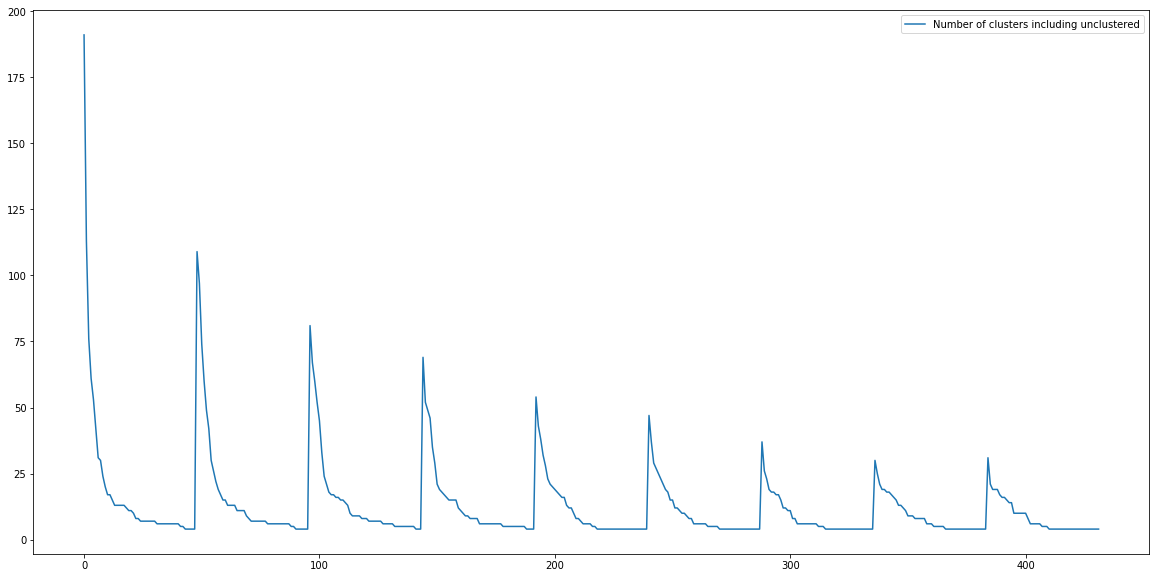

In [62]:
tmp, out = evaluate_hdbscan(input_df=maternalhealth_data, 
                       min_samples=Config.tune_min_sample, 
                       min_cluster_size=Config.tune_min_cluster,
                       output=OUTPUT, cluster_selection_method ='leaf',
                       fmin_samples=3, fmin_cluster_size=12,
                       prune=True)

In [64]:
tmp = tmp[tmp['num_clusters_including_unclustered'] < 10]
tmp = tmp.loc[tmp['num_clusters_including_unclustered'] > 4].sort_values(by='percent_of_unclustered_geos', ascending=True)
tmp.sort_values(by='percent_of_unclustered_geos', ascending=True).head(50)

,min_samples,min_cluster_size,num_clusters_including_unclustered,percent_of_unclustered_geos,percent_of_maxclass
37,1,39,6,47.97,15.47
35,1,37,6,47.97,15.47
39,1,41,6,47.97,15.47
38,1,40,6,47.97,15.47
36,1,38,6,47.97,15.47
32,1,34,6,47.97,15.47
42,1,44,5,47.97,22.03
33,1,35,6,47.97,15.47
31,1,33,6,47.97,15.47
40,1,42,6,47.97,15.47


##  Material and methods:
- Key indicators for child health (DHIS2 program): 
    - Percent of breast feeding initiated within 1 hour by CSBA
    - Percent of stunting by IMCI
    - Percent of underweight by IMCI
    - Percent of wasting by IMCI
    - Neonatal case fatality rate (EmOC)
    - Percentage of diarrhea reported at facility
    - Percentage of pneumonia reported at facility
- Time period from 2009 to 2018 at zila level

# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------

## PART 2: Running the clustering
### STEP 1: Get files list

In [65]:
dfiles = get_files_list(input_dir=DATA)
print(dfiles)

['/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2012_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2013_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2018_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2009_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2015_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2014_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2011_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2010_NAME.csv', '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhis2/health_indicators/District_2016_NAME.csv', '/Users/edinhamzic

### STEP 2: Read data

In [66]:
ddata = read_data(files_list=dfiles)

### STEP3: Check data 

In [67]:
dcheck = check_data(ddict=ddata)
dcheck

False

### STEP4: Concat data 

In [68]:
ddf = concat_data2(ddict=ddata)
display(ddf.head())
print(ddf.shape)
print(ddf.shape)


2012
2013
2018
2009
2015
2014
2011
2010
2016
2017


,01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Total Complicated Mother,01MaternalHealth: Total No. of pregnant mothers with obstetric complication,...,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for logistic closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for vaccine/diluent closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_supply book closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_temperature chart closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_zip lock bag closing balance,AntenatalCare(ANC): 1st Visit ANC,AntenatalCare(ANC): 2nd Visit ANC,AntenatalCare(ANC): 3rd & more ANC,geo,year
0,50.0,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006,5637.0,3244.0,...,36.9,36.9,50.9,330.0,311.0,NaN,NaN,NaN,Bagerhat District,2012
1,0.0,11.3,88.2,0.0770,0.08,0.42,0.0042,0.0008,463.0,316.0,...,38.0,29.0,32.0,218.0,534.0,NaN,NaN,NaN,Bandarban District,2012
2,20.0,49.4,50.0,0.0763,0.31,1.13,0.0113,0.0031,3558.0,3360.0,...,14.0,18.0,8.0,5.0,1240.0,NaN,NaN,NaN,Barguna District,2012
3,0.0,65.4,34.5,0.0039,0.04,0.78,0.0078,0.0004,4223.0,4128.0,...,50.0,45.0,47.0,897.0,2428.0,NaN,NaN,NaN,Barishal District,2012
4,26.0,22.1,77.4,0.2378,0.16,2.75,0.0275,0.0016,9348.0,9075.0,...,32.0,30.0,29.0,734.9,2772.4,NaN,NaN,NaN,Bhola District,2012


(640, 350)
(640, 350)


### STEP 5: Update geography

In [69]:
ddf['geo'] = ddf['geo'].str.replace(" District", "")
ddf = update_geo1(input_df=ddf,input_geo=GEOFILE, geo_var='Zila_Name2')

,geo_full,dv,Div_Name,zl,Zila_Name2
0,1004,10,Barisal,04,Barguna
17,1006,10,Barisal,06,Barishal
111,1009,10,Barisal,09,Bhola
143,1042,10,Barisal,42,Jhalokati
157,1078,10,Barisal,78,Patuakhali


,01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Total Complicated Mother,01MaternalHealth: Total No. of pregnant mothers with obstetric complication,...,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for logistic closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_stock register for vaccine/diluent closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_supply book closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_temperature chart closing balance,07Vaccine&LogisticsstockofUpazilaMunCC: upazilla_epi_zip lock bag closing balance,AntenatalCare(ANC): 1st Visit ANC,AntenatalCare(ANC): 2nd Visit ANC,AntenatalCare(ANC): 3rd & more ANC,geo,year
0,50.0,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006,5637.0,3244.0,...,36.9,36.9,50.9,330.0,311.0,NaN,NaN,NaN,Bagerhat,2012
1,0.0,11.3,88.2,0.0770,0.08,0.42,0.0042,0.0008,463.0,316.0,...,38.0,29.0,32.0,218.0,534.0,NaN,NaN,NaN,Bandarban,2012
2,20.0,49.4,50.0,0.0763,0.31,1.13,0.0113,0.0031,3558.0,3360.0,...,14.0,18.0,8.0,5.0,1240.0,NaN,NaN,NaN,Barguna,2012
3,0.0,65.4,34.5,0.0039,0.04,0.78,0.0078,0.0004,4223.0,4128.0,...,50.0,45.0,47.0,897.0,2428.0,NaN,NaN,NaN,Barishal,2012
4,26.0,22.1,77.4,0.2378,0.16,2.75,0.0275,0.0016,9348.0,9075.0,...,32.0,30.0,29.0,734.9,2772.4,NaN,NaN,NaN,Bhola,2012


(640, 355)


### STEP 6: Create output dir

In [70]:
create_output_dir(output_dir=Config.output)

Directory already present!


### STEP 6: Preparing data

In [71]:
maternalhealth_vars = [var for var in ddf.columns if bool(re.search(r"01MaternalHealth: ",var))]
print(maternalhealth_vars)
maternalhealth_data = ddf[['geo', 'year']+maternalhealth_vars]
maternalhealth_data = maternalhealth_data.drop(['01MaternalHealth: Total Complicated Mother', 
                                          '01MaternalHealth: Total No. of pregnant mothers with obstetric complication',
                                          '01MaternalHealth: Total birth in EmONC facilities', 
                                          '01MaternalHealth: Total deliveries in EmONC facilities',
                                          '01MaternalHealth: Total still birth at EmOC facility'],axis=1)
maternalhealth_data.head()


['01MaternalHealth: % of maternal death reported individually with causes of death', '01MaternalHealth: Institutional C-section rate', '01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)', '01MaternalHealth: Maternal Case fatality rate (EmOC)', '01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC', '01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC', '01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC', '01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC', '01MaternalHealth: Total Complicated Mother', '01MaternalHealth: Total No. of pregnant mothers with obstetric complication', '01MaternalHealth: Total birth in EmONC facilities', '01MaternalHealth: Total deliveries in EmONC facilities', '01MaternalHealth: Total still birth at EmOC facility']


,geo,year,01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC
0,4001,2012,50.00,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006
1,4001,2013,33.33,30.5,68.8,0.0986,0.03,0.68,0.0068,0.0003
2,4001,2018,125.00,29.3,70.4,0.0471,0.04,1.10,0.0110,0.0004
3,4001,2009,125.00,30.1,69.6,0.0512,0.04,1.04,0.0104,0.0004
4,4001,2015,83.33,31.9,67.5,0.0377,0.02,0.77,0.0077,0.0002


In [72]:
maternalhealth_data = imput_missing(input_df=maternalhealth_data)


## STEP 7: Clustering data and assigning collors

- Two clustering set of parameters:  min_sample=1, min_cluster_size=29. Clusters: 4, Unclustered: 27.03%, Max class: 52.19%	
				

In [73]:
print(maternalhealth_data.shape)
datad_option1 = cluster_data(input_df=maternalhealth_data, f_min_samples=1, f_min_cluster_size=39, cluster_selection_method='leaf')
print(Counter(datad_option1['class']))
datad_option1, labs_cols = colors2clusters(df_input=datad_option1, cluster_var='class')
display(datad_option1.head())

(640, 10)
Index(['01MaternalHealth: Institutional C-section rate',
       '01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)',
       '01MaternalHealth: Maternal Case fatality rate (EmOC)',
       '01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC',
       '01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC',
       '01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC',
       '01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC',
       '01MaternalHealth: % of maternal death reported individually with causes of death'],
      dtype='object')
Counter({-1: 307, 4: 99, 0: 89, 2: 59, 1: 44, 3: 42})
Counter({-1: 307, 4: 99, 0: 89, 2: 59, 1: 44, 3: 42})


,geo,year,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: % of maternal death reported individually with causes of death,class,colors
0,4001,2012,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006,50.00,0,#1f78b4
1,4001,2013,30.5,68.8,0.0986,0.03,0.68,0.0068,0.0003,33.33,1,#b2df8a
2,4001,2018,29.3,70.4,0.0471,0.04,1.10,0.0110,0.0004,125.00,-1,#a6cee3
3,4001,2009,30.1,69.6,0.0512,0.04,1.04,0.0104,0.0004,125.00,-1,#a6cee3
4,4001,2015,31.9,67.5,0.0377,0.02,0.77,0.0077,0.0002,83.33,-1,#a6cee3


In [31]:
print(maternalhealth_data.shape)
datad_option2 = cluster_data(input_df=maternalhealth_data, f_min_samples=3, f_min_cluster_size=24, cluster_selection_method='eom')
print(Counter(datad_option2['class']))
datad_option2, labs_cols = colors2clusters(df_input=datad_option2, cluster_var='class')
display(datad_option2.head())

(640, 10)
Index(['01MaternalHealth: Institutional C-section rate',
       '01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)',
       '01MaternalHealth: Maternal Case fatality rate (EmOC)',
       '01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC',
       '01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC',
       '01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC',
       '01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC',
       '01MaternalHealth: % of maternal death reported individually with causes of death'],
      dtype='object')
Counter({2: 316, -1: 198, 0: 54, 3: 46, 1: 26})
Counter({2: 316, -1: 198, 0: 54, 3: 46, 1: 26})


,geo,year,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: Maternal Case fatality rate (EmOC),01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: % of maternal death reported individually with causes of death,class,colors
0,4001,2012,36.6,63.0,0.0699,0.06,0.74,0.0074,0.0006,50.00,1,#b2df8a
1,4001,2013,30.5,68.8,0.0986,0.03,0.68,0.0068,0.0003,33.33,3,#fb9a99
2,4001,2018,29.3,70.4,0.0471,0.04,1.10,0.0110,0.0004,125.00,-1,#a6cee3
3,4001,2009,30.1,69.6,0.0512,0.04,1.04,0.0104,0.0004,125.00,-1,#a6cee3
4,4001,2015,31.9,67.5,0.0377,0.02,0.77,0.0077,0.0002,83.33,-1,#a6cee3


### STEP 9: Getting statistics

In [74]:
output_table(input_df=datad_option1)


['01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC', '01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC', '01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC', '01MaternalHealth: Institutional C-section rate', '01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)', '01MaternalHealth: % of maternal death reported individually with causes of death', '01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC', '01MaternalHealth: Maternal Case fatality rate (EmOC)', 'class']


,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Maternal Case fatality rate (EmOC)
class,,,,,,,,
-1,0.001 - 0.0 - 0.0544,0.0 - 0.2 - 1.61,0.0 - 0.0 - 0.0161,7.8 - 42.2 - 76.9,22.6 - 56.7 - 90.0,0.0 - 95.4 - 5800.0,0.1 - 1.2 - 5.44,0.0 - 0.1 - 0.4642
0,0.0012 - 0.0 - 0.0236,0.0 - 0.2 - 1.87,0.0 - 0.0 - 0.0187,31.8 - 49.8 - 66.9,33.1 - 49.3 - 64.7,42.86 - 54.4 - 65.71,0.12 - 0.9 - 2.36,0.0 - 0.0 - 0.2865
1,0.0018 - 0.0 - 0.0291,0.0 - 0.1 - 0.48,0.0 - 0.0 - 0.0048,21.8 - 31.9 - 43.1,55.4 - 67.1 - 77.7,26.92 - 37.5 - 50.0,0.18 - 1.3 - 2.91,0.0165 - 0.1 - 0.3304
2,0.0018 - 0.0 - 0.0326,0.01 - 0.2 - 0.83,0.0001 - 0.0 - 0.0083,45.9 - 56.4 - 63.1,36.9 - 43.2 - 52.8,0.0 - 0.6 - 5.88,0.18 - 0.8 - 3.26,0.0011 - 0.1 - 0.7014
3,0.0005 - 0.0 - 0.0297,0.01 - 0.4 - 1.94,0.0001 - 0.0 - 0.0194,41.9 - 48.0 - 52.8,47.1 - 51.0 - 57.0,2.94 - 7.9 - 16.67,0.05 - 1.3 - 2.97,0.0063 - 0.1 - 0.3473
4,0.0015 - 0.0 - 0.0374,0.0 - 0.2 - 1.06,0.0 - 0.0 - 0.0106,10.1 - 29.4 - 44.3,55.6 - 69.9 - 89.0,0.0 - 2.3 - 20.59,0.15 - 1.3 - 3.74,0.0025 - 0.1 - 2.074


In [48]:
output_table(input_df=datad_option2)

['01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC', '01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC', '01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC', '01MaternalHealth: Institutional C-section rate', '01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities)', '01MaternalHealth: % of maternal death reported individually with causes of death', '01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC', '01MaternalHealth: Maternal Case fatality rate (EmOC)', 'class']


,01MaternalHealth: Proportion of cases with postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Percentage of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Proportion of cases with puerperal sepsis among admitted patient in EmONC,01MaternalHealth: Institutional C-section rate,01MaternalHealth: Institutional Normal Delivery Rate (Only EmOC Facilities),01MaternalHealth: % of maternal death reported individually with causes of death,01MaternalHealth: Percentage of postpartum hemorrhage among admitted patient in EmONC,01MaternalHealth: Maternal Case fatality rate (EmOC)
class,,,,,,,,
-1,0.0017 - 0.0 - 0.0331,0.0 - 0.2 - 1.76,0.0 - 0.0 - 0.0176,7.8 - 40.9 - 76.9,22.6 - 57.9 - 90.0,2.09 - 141.5 - 5800.0,0.17 - 1.1 - 3.31,0.0 - 0.1 - 0.3208
0,0.0012 - 0.0 - 0.0236,0.03 - 0.2 - 1.59,0.0003 - 0.0 - 0.0159,44.7 - 57.1 - 66.9,33.1 - 42.2 - 52.7,45.74 - 54.2 - 60.0,0.12 - 0.9 - 2.36,0.0 - 0.0 - 0.1788
1,0.0014 - 0.0 - 0.0194,0.0 - 0.2 - 1.87,0.0 - 0.0 - 0.0187,33.8 - 37.9 - 44.4,55.6 - 60.7 - 64.0,50.0 - 53.8 - 58.97,0.14 - 0.9 - 1.94,0.0 - 0.0 - 0.1719
2,0.0005 - 0.0 - 0.0544,0.0 - 0.2 - 1.94,0.0 - 0.0 - 0.0194,10.1 - 42.0 - 67.4,32.5 - 57.2 - 89.0,0.0 - 7.5 - 30.0,0.05 - 1.2 - 5.44,0.0011 - 0.1 - 2.074
3,0.0018 - 0.0 - 0.0291,0.0 - 0.2 - 0.93,0.0 - 0.0 - 0.0093,24.7 - 34.7 - 51.2,47.9 - 64.4 - 74.7,29.17 - 36.6 - 50.0,0.18 - 1.3 - 2.91,0.0151 - 0.1 - 0.3304


In [75]:
clusters = output_class(input_df=datad_option1)
clusters = update_geo2(input_df=clusters, input_geo=GEOFILE, geo_var='geo_full')
clusters.sort_values([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018], ascending=False)

,geo,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,geo,dv,Div_Name,zl,Zila_Name2
9,2015,4,4,4,4,4,4,4,4,4,4,2015,20,Chittagong,15,Chattogram
12,2019,4,4,4,4,4,4,4,4,4,4,2019,20,Chittagong,19,Cumilla
38,3059,4,4,4,4,4,4,4,4,4,4,3059,30,Dhaka,59,Munshiganj
6,2012,4,4,4,4,4,4,2,4,2,4,2012,20,Chittagong,12,Brahmanbaria
57,3086,2,2,4,2,2,2,2,2,2,2,3086,30,Dhaka,86,Shariatpur
13,3026,2,2,2,2,2,2,2,2,2,2,3026,30,Dhaka,26,Dhaka
41,4065,2,2,2,2,2,2,2,2,2,2,4065,40,Khulna,65,Narail
10,4018,2,2,2,2,-1,2,2,2,2,2,4018,40,Khulna,18,Chuadanga
29,5549,1,1,-1,-1,4,1,1,-1,1,1,5549,55,Rangpur,49,Kurigram
59,5088,1,1,-1,-1,-1,-1,-1,-1,-1,1,5088,50,Rajshahi,88,Sirajganj


In [35]:
clusters = output_class(input_df=datad_option2)
clusters = update_geo2(input_df=clusters, input_geo=GEOFILE, geo_var='geo_full')
clusters.sort_values([2009,2010,2011,2012,2013,2014,2015,2016,2017,2018], ascending=False)

,geo,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,geo,dv,Div_Name,zl,Zila_Name2
29,5549,3,3,2,2,2,3,3,2,3,3,5549,55,Rangpur,49,Kurigram
59,5088,3,3,-1,-1,-1,-1,2,2,2,3,5088,50,Rajshahi,88,Sirajganj
34,4055,3,2,2,2,2,2,2,2,3,-1,4055,40,Khulna,55,Magura
40,5064,3,2,2,2,2,2,2,2,2,3,5064,50,Rajshahi,64,Naogaon
5,5010,2,2,2,2,2,2,2,2,2,2,5010,50,Rajshahi,10,Bogura
6,2012,2,2,2,2,2,2,2,2,2,2,2012,20,Chittagong,12,Brahmanbaria
9,2015,2,2,2,2,2,2,2,2,2,2,2015,20,Chittagong,15,Chattogram
10,4018,2,2,2,2,2,2,2,2,2,2,4018,40,Khulna,18,Chuadanga
12,2019,2,2,2,2,2,2,2,2,2,2,2019,20,Chittagong,19,Cumilla
13,3026,2,2,2,2,2,2,2,2,2,2,3026,30,Dhaka,26,Dhaka


### STEP 8: Plotting clusters: datad_option1

[2009]


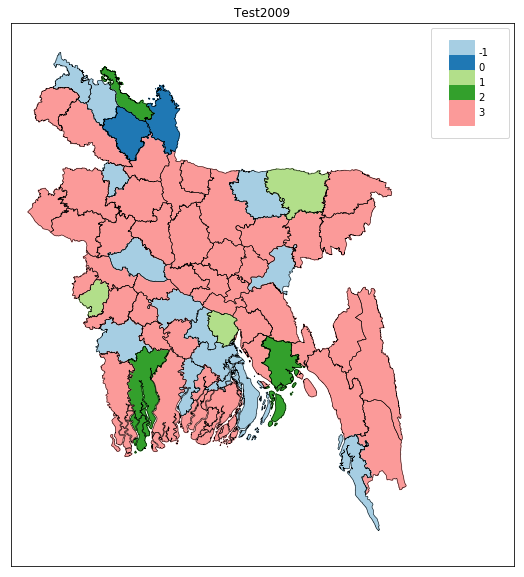

[2010]


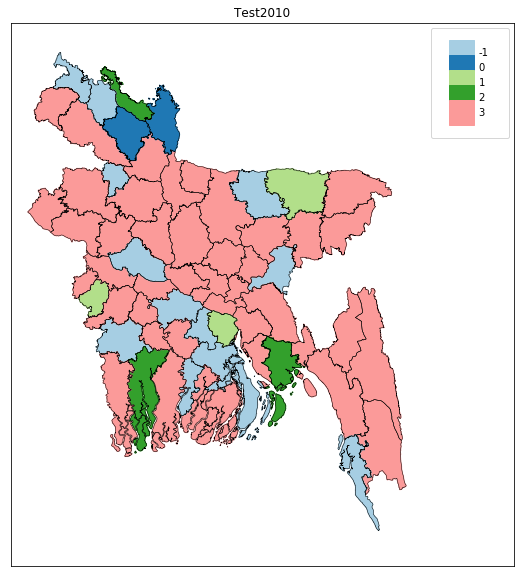

[2011]


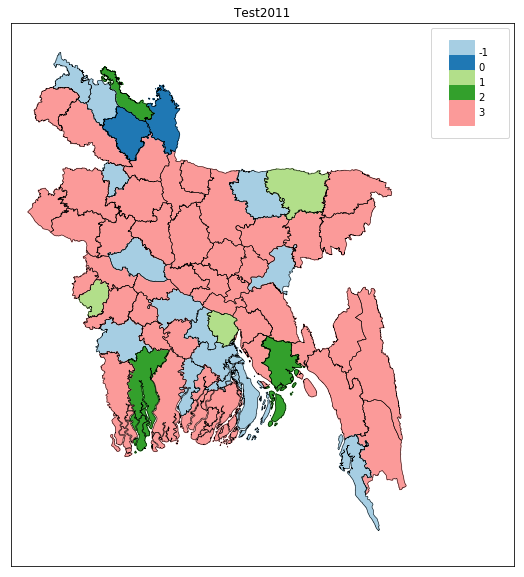

[2012]


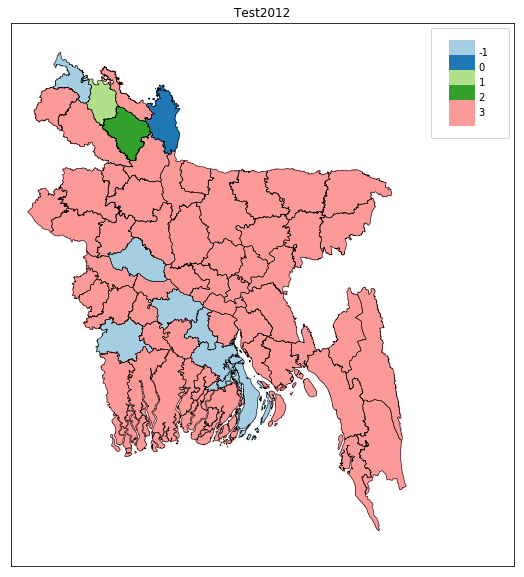

[2013]


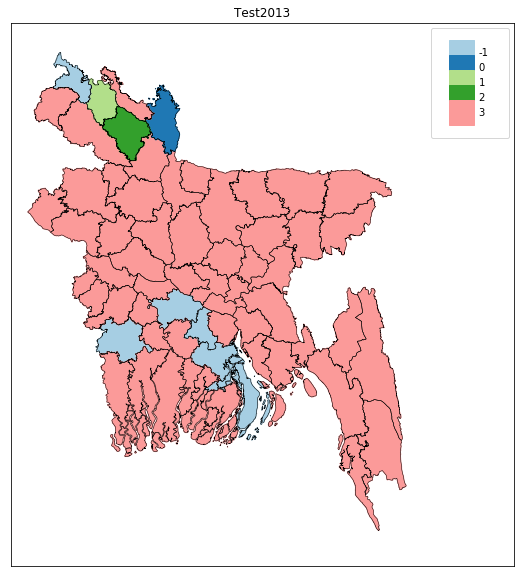

[2014]


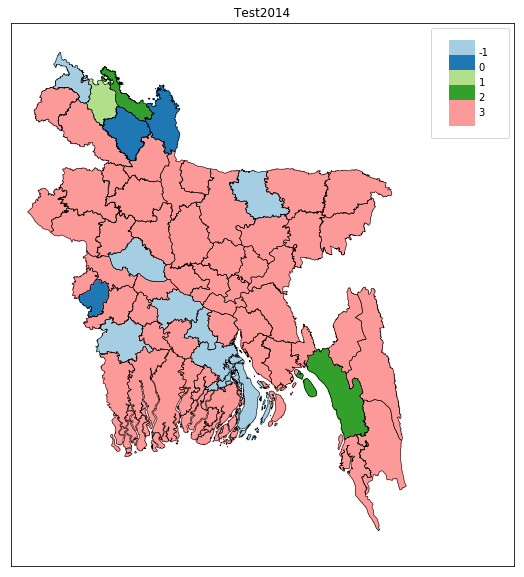

[2015]


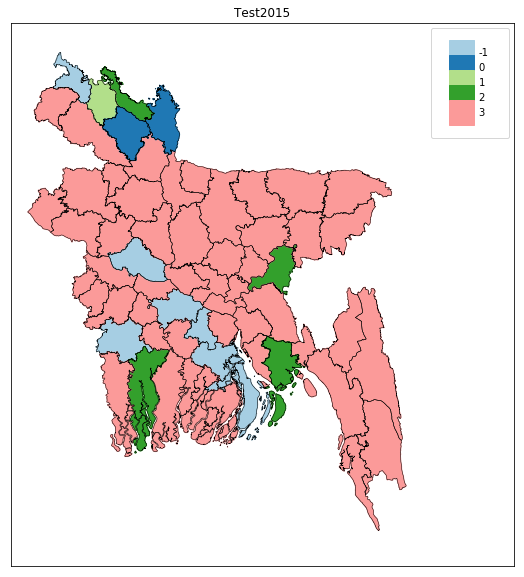

[2016]


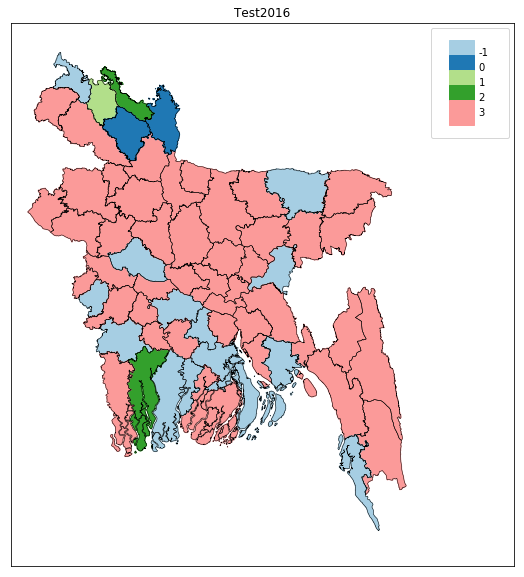

[2017]


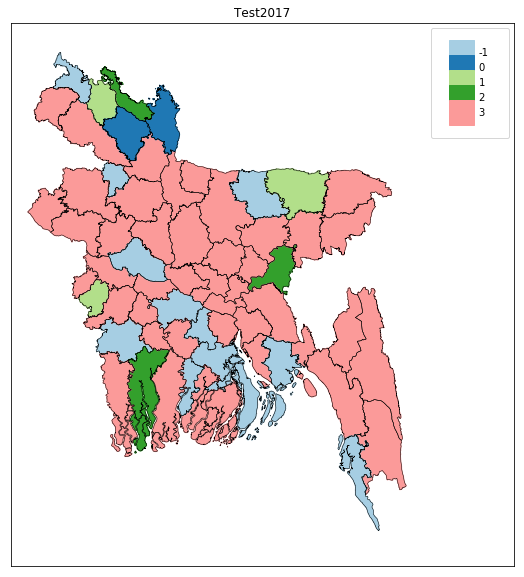

[2018]


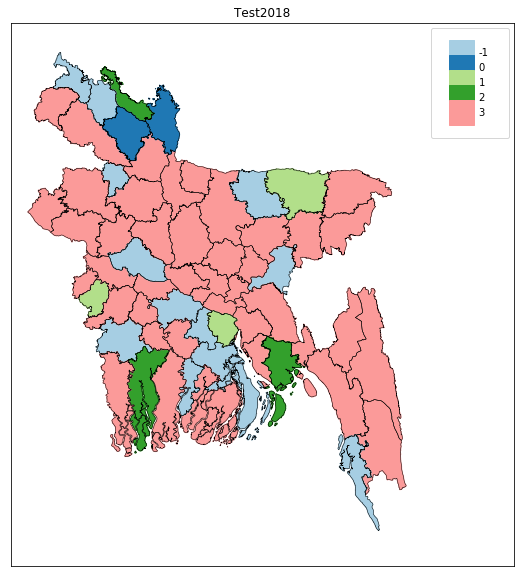

In [158]:
plot_clusters(input_df=datad_option1, shapefile=SHAPEFILE, geo_level=GEO_LEVEL, project=Config.project, output=OUTPUT)

In [ ]:
stats = get_statistics(input_df=datad_option1, output=OUTPUT, title=Config.project)
stats